# Weibull Options Comparison


In [1]:
import PV_ICE
import numpy as np
import matplotlib.pyplot as plt

r1 = PV_ICE.Simulation(name='Simulation1')

baselinefile = r'C:\Users\sayala\Documents\GitHub\CircularEconomy-MassFlowCalculator\PV_ICE\baselines\baseline_modules_US.csv'
materialfile = r'C:\Users\sayala\Documents\GitHub\CircularEconomy-MassFlowCalculator\PV_ICE\baselines\baseline_material_glass.csv'
r1.createScenario(name='standard', file=baselinefile)
r1.scenario['standard'].addMaterial('glass', file=materialfile)


path = C:\Users\sayala\Documents\GitHub\CircularEconomy-MassFlowCalculator\docs\tutorials


#### A. Internally calculated Weibull with t50 and t90

In [2]:
r1.calculateMassFlow()
print(r1.scenario['standard'].data.WeibullParams.head())

Working on Scenario:  standard
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
0    {'alpha': 4.173167120209922, 'beta': 16.376973...
1    {'alpha': 4.173167120209922, 'beta': 16.376973...
2    {'alpha': 4.414845594612703, 'beta': 17.384986...
3    {'alpha': 4.414845594612703, 'beta': 17.384986...
4    {'alpha': 4.656360831712505, 'beta': 18.392181...
Name: WeibullParams, dtype: object


#### B. Passing Alpha and Beta values

In [3]:
weibullInputParams = {'alpha': 3.4,
                      'beta': 4.5}
r1.calculateMassFlow(weibullInputParams=weibullInputParams)
print(r1.scenario['standard'].data.WeibullParams.head())

Working on Scenario:  standard
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
0    {'alpha': 3.4, 'beta': 4.5}
1    {'alpha': 3.4, 'beta': 4.5}
2    {'alpha': 3.4, 'beta': 4.5}
3    {'alpha': 3.4, 'beta': 4.5}
4    {'alpha': 3.4, 'beta': 4.5}
Name: WeibullParams, dtype: object


#### C. Passing Alpha only

In [4]:
weibullInputParams = {'alpha': 5.3759}  # Regular-loss scenario IRENA

r1.calculateMassFlow(weibullInputParams=weibullInputParams, weibullAlphaOnly=True)
print(r1.scenario['standard'].data.WeibullParams.head())


Working on Scenario:  standard
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
0    5.3759
1    5.3759
2    5.3759
3    5.3759
4    5.3759
Name: WeibullParams, dtype: float64


## Going internally to plot. This is custom code.

In [5]:
def weibull_cdf(alpha, beta):
    '''Return the CDF for a Weibull distribution having:
    shape parameter `alpha`
    scale parameter `beta`'''
    def cdf(x):
        return 1 - np.exp(-(np.array(x)/beta)**alpha)
    return cdf

def weibull_pdf(alpha, beta):
    '''Return the PDF for a Weibull distribution having:
        shape parameter `alpha`
        scale parameter `beta`/'''
    def pdf(x):
        return (alpha/np.array(x)) * ((np.array(x)/beta)**alpha) * (np.exp(-(np.array(x)/beta)**alpha))
    return pdf

def weibull_cdf_alphaonly(alpha, Lifetime):
    '''Return the CDF for a Weibull distribution having:
    shape parameter `alpha`
    scale parameter `beta`'''
    def cdf(x):
        return 1 - np.exp(-(np.array(x)/Lifetime)**alpha)
    return cdf


def weibull_params(keypoints):
    '''Returns shape parameter `alpha` and scale parameter `beta`
    for a Weibull distribution whose CDF passes through the
    two time: value pairs in `keypoints`'''
    t1, t2 = tuple(keypoints.keys())
    cdf1, cdf2 = tuple(keypoints.values())
    alpha = np.ndarray.item(np.real_if_close(
        (np.log(np.log(1 - cdf1)+0j) - np.log(np.log(1 - cdf2)+0j))/(np.log(t1) - np.log(t2))
    ))
    beta = np.abs(np.exp(
        (
            np.log(t2)*((0+1j)*np.pi + np.log(np.log(1 - cdf1)+0j))
            + np.log(t1)*(((0-1j))*np.pi - np.log(np.log(1 - cdf2)+0j))
        )/(
            np.log(np.log(1 - cdf1)+0j) - np.log(np.log(1 - cdf2)+0j)
        )
    ))
    return {'alpha': alpha, 'beta': beta}




In [6]:
df = r1.scenario['standard'].data

# Constant
irradiance_stc = 1000 # W/m^2

# Renaming and re-scaling
df['new_Installed_Capacity_[W]'] = df['new_Installed_Capacity_[MW]']*1e6
df['t50'] = df['mod_reliability_t50']
df['t90'] = df['mod_reliability_t90']

# Calculating Area and Mass
df['Area'] = df['new_Installed_Capacity_[W]']/(df['mod_eff']*0.01)/irradiance_stc # m^2                
df['Area'] = df['Area'].fillna(0) # Chagne na's to 0s.

# Calculating Wast by Generation by Year, and Cumulative Waste by Year.
Generation_Disposed_byYear = []
Generation_Active_byYear= []
Generation_Power_byYear = []

df['Cumulative_Area_disposedby_Failure'] = 0
df['Cumulative_Area_disposedby_ProjectLifetime'] = 0
df['Cumulative_Area_disposed'] = 0
df['Cumulative_Active_Area'] = 0
df['Installed_Capacity_[W]'] = 0


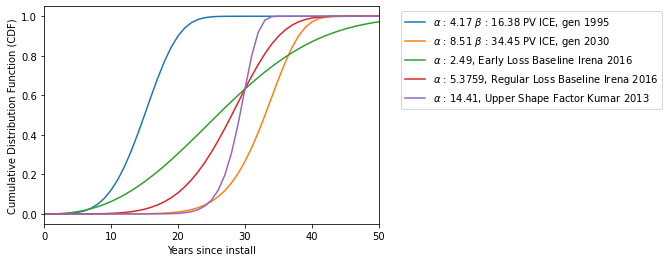

In [37]:
df = r1.scenario['standard'].data

#for generation, row in df.iterrows(): 
    #generation is an int 0,1,2,.... etc.
generation=0
row=df.iloc[generation]

t50, t90 = row['t50'], row['t90']   #  t50 = 17.0; t90 = 22.0
weibullInputParams = weibull_params({t50: 0.50, t90: 0.90})      #  alpha = 4.65, beta = 18.39
f = weibull_cdf(**weibull_params({t50: 0.50, t90: 0.90}))
x = np.clip(df.index - generation, 0, np.inf)
cdf = list(map(f, x))


generation=40
row=df.iloc[generation]
t50, t90 = row['t50'], row['t90']   #  t50 = 17.0; t90 = 22.0
weibullInputParams2 = weibull_params({t50: 0.50, t90: 0.90})      #  alpha = 4.65, beta = 18.39
g = weibull_cdf(**weibull_params({t50: 0.50, t90: 0.90}))
generation = 0
x = np.clip(df.index - generation, 0, np.inf)
gdf = list(map(g, x))


#weibullInputParams = {'alpha': 3.4,
#                      'beta': 4.5}

#g = weibull_cdf(weibullInputParams['alpha'], weibullInputParams['beta'])
#x = np.clip(df.index - generation, 0, np.inf)
#gdf = list(map(g, x))

h = weibull_cdf_alphaonly(2.4928, 30)
x = np.clip(df.index - generation, 0, np.inf)
hdf = list(map(h, x))

j = weibull_cdf_alphaonly(5.3759, 30)
x = np.clip(df.index - generation, 0, np.inf)
jdf = list(map(j, x))

i = weibull_cdf_alphaonly(14.41, 30)
x = np.clip(df.index - generation, 0, np.inf)
idf = list(map(i, x))



plt.plot(cdf, label=r'$ \alpha $ : '+str(round(weibullInputParams['alpha'],2))+ r' $ \beta $ : '+ str(round(weibullInputParams['beta'],2)) + ' PV ICE, gen 1995')
plt.plot(gdf, label=r'$ \alpha $ : '+str(round(weibullInputParams2['alpha'],2))+ r' $ \beta $ : '+ str(round(weibullInputParams2['beta'],2)) + ' PV ICE, gen 2030')
plt.plot(hdf, label=r'$ \alpha $ : 2.49, Early Loss Baseline Irena 2016')
plt.plot(jdf, label=r'$ \alpha $ : 5.3759, Regular Loss Baseline Irena 2016')
plt.plot(idf, label=r'$ \alpha $ : 14.41, Upper Shape Factor Kumar 2013')
plt.legend()
plt.ylabel('Cumulative Distribution Function (CDF)')
plt.xlabel('Years since install')
plt.xlim([0,50])
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

#   pdf = [0] + [j - i for i, j in zip(cdf[: -1], cdf[1 :])]

# In[3]:

0.26015567892278924